# ARFS vs MRmr

Maximal relevance minimal redundancy feature selection is, theoretically, a subset of all relevant feature selection. However, contrary to the provided ARFS method, there is no criterion for the number of features to select. This is a hyper-parameter, found by HPO or set by the User. 
On the other hand, ARFS methods are negatively impacted in presence of collinearity while those collinear features are penalized in the MRmr (redundancy part).


In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import gc
import arfs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sys import getsizeof, path
from sklearn.pipeline import Pipeline
from arfs.utils import load_data
from arfs.feature_selection import (
    MinRedundancyMaxRelevance,
    GrootCV,
    MissingValueThreshold,
    UniqueValuesThreshold,
    CollinearityThreshold,
    make_fs_summary,
)
from arfs.benchmark import highlight_tick

# plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

import warnings

warnings.filterwarnings("ignore")

In [2]:
print(f"Run with ARFS {arfs.__version__}")

Run with ARFS 2.3.1


In [3]:
gc.enable()
gc.collect()

0

## MRmr

convenient, handles collinearity but does not automatically detect the number of features to select (let as a hyper-param).

In [4]:
boston = load_data(name="Boston")
X, y = boston.data, boston.target
y.name = "target"

In [5]:
y.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: target, dtype: float64

In [6]:
X.dtypes

CRIM             float64
ZN               float64
INDUS            float64
CHAS            category
NOX              float64
RM               float64
AGE              float64
DIS              float64
RAD             category
TAX              float64
PTRATIO          float64
B                float64
LSTAT            float64
random_num1      float64
random_num2        int32
random_cat      category
random_cat_2    category
genuine_num      float64
dtype: object

In [7]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,random_num1,random_num2,random_cat,random_cat_2,genuine_num
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,0.496714,0,cat_3517,Platist,7.080332
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,-0.138264,0,cat_2397,MarkZ,5.245384
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,0.647689,0,cat_3735,Dracula,6.375795
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,1.523030,0,cat_2870,Bejita,6.725118
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,-0.234153,4,cat_1160,Variance,7.867781


In [8]:
# the number of features is a hyper-param

fs_mrmr = MinRedundancyMaxRelevance(
    n_features_to_select=10,
    relevance_func=None,
    redundancy_func=None,
    task="regression",  # "classification",
    denominator_func=np.mean,
    only_same_domain=False,
    return_scores=False,
    show_progress=True,
    n_jobs=1,
)

# fs_mrmr.fit(X=X, y=y.astype(str), sample_weight=None)
fs_mrmr.fit(X=X, y=y, sample_weight=None)

  0%|          | 0/10 [00:00<?, ?it/s]

MinRedundancyMaxRelevance(n_features_to_select=10,
                          redundancy_func=functools.partial(<function association_series at 0x7dd0785d0720>, n_jobs=1, normalize=True),
                          relevance_func=functools.partial(<function f_stat_regression_parallel at 0x7dd0785d0c20>, n_jobs=1))

In [9]:
X_trans = fs_mrmr.transform(X)
X_trans.head()

,LSTAT,genuine_num,CHAS,RAD,RM,INDUS,TAX,NOX,CRIM,PTRATIO
0,4.98,7.080332,0.0,1.0,6.575,2.31,296.0,0.538,0.00632,15.3
1,9.14,5.245384,0.0,2.0,6.421,7.07,242.0,0.469,0.02731,17.8
2,4.03,6.375795,0.0,2.0,7.185,7.07,242.0,0.469,0.02729,17.8
3,2.94,6.725118,0.0,3.0,6.998,2.18,222.0,0.458,0.03237,18.7
4,5.33,7.867781,0.0,3.0,7.147,2.18,222.0,0.458,0.06905,18.7


In [10]:
fs_mrmr.feature_names_in_

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT', 'random_num1', 'random_num2',
       'random_cat', 'random_cat_2', 'genuine_num'], dtype=object)

In [11]:
fs_mrmr.support_

array([ True, False,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True, False, False, False, False,  True])

In [12]:
fs_mrmr.get_feature_names_out()

array(['CRIM', 'INDUS', 'CHAS', 'NOX', 'RM', 'RAD', 'TAX', 'PTRATIO',
       'LSTAT', 'genuine_num'], dtype=object)

In [13]:
fs_mrmr.ranking_

,mrmr,relevance,redundancy
LSTAT,inf,3.026693,0.000000
genuine_num,1131.029947,1.131030,0.001000
CHAS,1.787263,0.731266,0.409154
RAD,2.262116,0.990593,0.437905
RM,0.571875,0.145600,0.254601
INDUS,-0.324591,-0.096957,0.298705
TAX,-0.358787,-0.154209,0.429805
NOX,-0.328722,-0.153521,0.467023
CRIM,-0.324877,-0.166310,0.511916
PTRATIO,-0.381959,-0.176410,0.461857


## ARFS - GrootCV

Cross-validated, using a stopping criterion for the features to select, does not play well with high collinearity.

In [14]:
boston = load_data(name="Boston")
X, y = boston.data, boston.target
y.name = "target"

Cross Validation:   0%|          | 0/25 [00:00<?, ?it/s]

The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']
The agnostic ranking: [2 1 1 1 2 2 2 2 1 2 2 1 2 1 1 1 1 2]
The naive ranking: ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'CRIM', 'NOX', 'AGE', 'B', 'ShadowVar1', 'ShadowVar13', 'INDUS', 'ShadowVar14', 'ShadowVar12', 'ShadowVar10', 'ShadowVar11', 'RAD', 'ShadowVar15', 'CHAS']


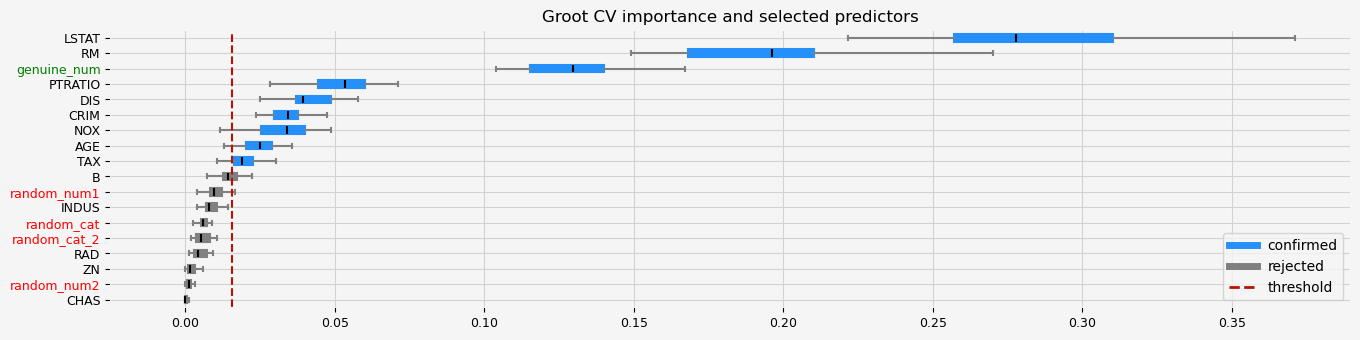

CPU times: user 53.2 s, sys: 655 ms, total: 53.9 s
Wall time: 20.1 s


In [15]:
%%time
# GrootCV
feat_selector = GrootCV(objective="rmse", cutoff=1, n_folds=5, n_iter=5, silent=True)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

Using a pipeline for filtering out collinear features and improving the stability of the selection

In [16]:
feat_selector = GrootCV(objective="rmse", cutoff=1, n_folds=5, n_iter=5, silent=True)

arfs_fs_pipeline = Pipeline(
    [
        ("missing", MissingValueThreshold(threshold=0.05)),
        ("unique", UniqueValuesThreshold(threshold=1)),
        ("collinearity", CollinearityThreshold(threshold=0.85)),
        ("arfs", feat_selector),
    ]
)

X_trans = arfs_fs_pipeline.fit(X=X, y=y).transform(X=X)

Cross Validation:   0%|          | 0/25 [00:00<?, ?it/s]

In [17]:
arfs_fs_pipeline.named_steps["collinearity"].get_feature_names_out()

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'random_num1', 'random_num2',
       'random_cat', 'random_cat_2', 'genuine_num'], dtype=object)

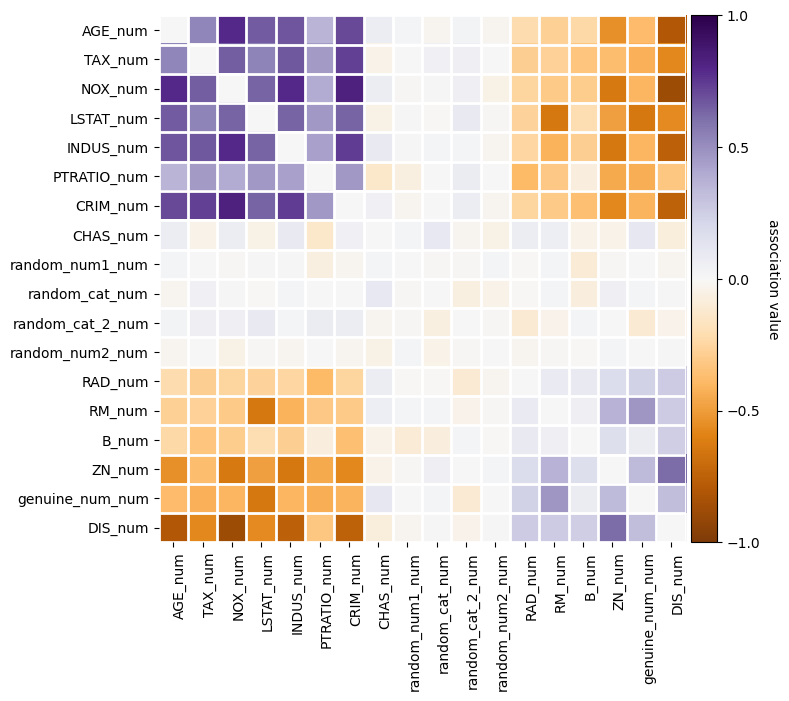

In [18]:
f = arfs_fs_pipeline.named_steps["collinearity"].plot_association(figsize=(8, 8))

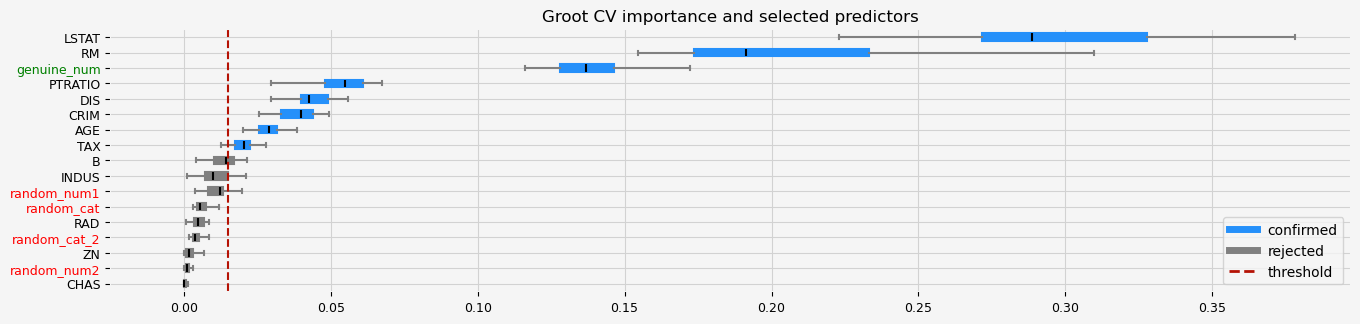

In [19]:
fig = arfs_fs_pipeline.named_steps["arfs"].plot_importance()
# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

In [20]:
make_fs_summary(arfs_fs_pipeline)

,predictor,missing,unique,collinearity,arfs
0,CRIM,1,1,1,1
1,ZN,1,1,1,0
2,INDUS,1,1,1,0
3,CHAS,1,1,1,0
4,NOX,1,1,0,nan
5,RM,1,1,1,1
6,AGE,1,1,1,1
7,DIS,1,1,1,1
8,RAD,1,1,1,0
9,TAX,1,1,1,1
